In [1]:
import torch
import torchvision
import random
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import logging

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [2]:
train=torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test=torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

100%|██████████| 9912422/9912422 [00:00<00:00, 346973154.33it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30605278.88it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 158603173.87it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20374897.08it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Create Imbalance MNIST dataset

In [3]:
train.data.shape

torch.Size([60000, 28, 28])

In [4]:
selection = torch.logical_or(train.targets == 2, train.targets == 7)
train.data = train.data[selection]
train.targets = train.targets[selection]


In [5]:
sample_probs = {'2':0.7, '7':0} #30% of 2s and 100% of 7s
idx_to_del = [i for i, label in enumerate(train.targets)  if random.random() > sample_probs[str(label.item())]]
print(idx_to_del)

[0, 1, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 27, 28, 30, 33, 34, 35, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 76, 79, 81, 84, 86, 87, 88, 89, 90, 92, 95, 96, 100, 101, 103, 104, 105, 107, 108, 109, 110, 115, 116, 118, 120, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 144, 145, 146, 147, 151, 154, 155, 156, 157, 158, 160, 161, 162, 164, 165, 166, 167, 168, 169, 172, 173, 174, 176, 178, 179, 183, 185, 186, 187, 188, 189, 190, 191, 193, 194, 196, 197, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 228, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 242, 243, 244, 246, 247, 249, 250, 251, 252, 254, 255, 257, 259, 260, 261, 262, 264, 265, 266, 267, 268, 270, 271, 273, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 295, 296, 297, 301, 303, 304,

In [6]:
#### Imbalanced now

In [7]:
train.data = train.data[idx_to_del]
train.targets = train.targets[idx_to_del].type(torch.float)
train.targets[train.targets==2] = 0
train.targets[train.targets==7] = 1
train.targets.unique(return_counts=True)

(tensor([0., 1.]), tensor([1845, 6265]))

In [8]:
selection = torch.logical_or(test.targets == 2, test.targets == 7)
test.data = test.data[selection].type(torch.float)
test.targets = test.targets[selection]
test.targets[test.targets==2] = 0
test.targets[test.targets==7] = 1

### Create the network for classification

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Net(nn.Module): # Simple CNN to classify dataset examples
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



### Configurations

In [11]:
n_epochs = 50
batch_size_train = 128
batch_size_test = 500
learning_rate = 0.01
momentum = 0.5
log_interval = 10
classe_labels = np.array([2,7])
random_seed = 1
torch.backends.cudnn.enabled = False
device = 'cuda'
torch.manual_seed(random_seed)

In [12]:
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size_test, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

In [13]:
def vis(train_loss, test_accs, confusion_mtxes, labels, figsize=(7, 5)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    fig = plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.semilogy(train_loss, 'r')

    plt.subplot(1, 3, 2)
    plt.plot(test_accs, 'g')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [14]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

### Train the classifier

In [15]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.01, 0.5)

train_loss = []
test_accs, confusion_mtxes = [], []
for epoch in range(1, n_epochs):
    model.train()
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(train_loader, position=0, leave=True)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        pbar.set_postfix(CE=loss.item())

    model.eval()
    correct = 0
    train_loss.append(loss.item())
    targets, preds = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output,dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()

            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

    test_acc = 100. * correct / len(test_loader.dataset)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    test_accs.append(test_acc)
    confusion_mtxes.append(confusion_mtx)
    print(epoch)
    print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)


  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 50.29%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 58.74%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 75.83%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 83.69%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 88.98%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

  0%|          | 0/64 [00:00<?, ?it/s]

Best test acc = 89.47%

f1 score is 0.5225770920663428


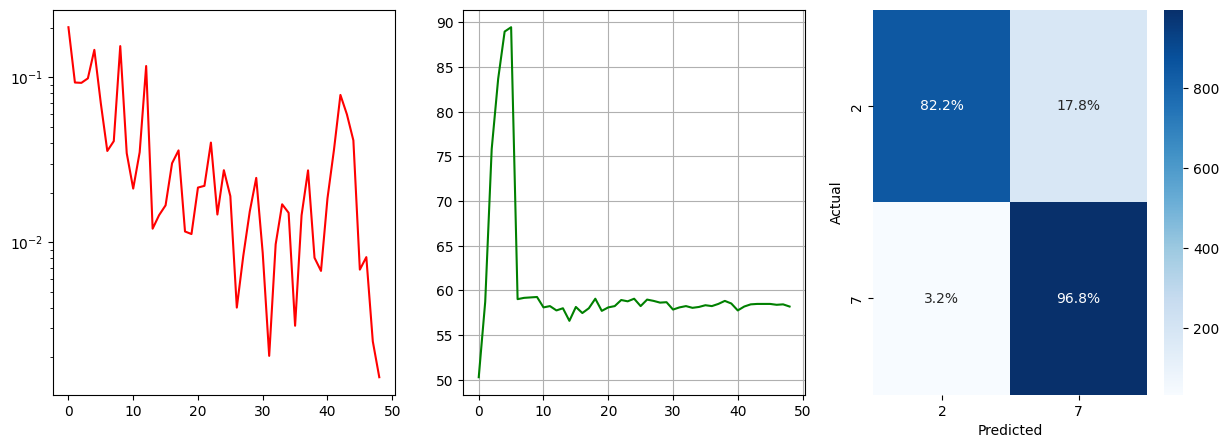

In [16]:
f1 = f1_score(targets, preds, average='macro')
print(f'f1 score is {f1}')
vis(train_loss, test_accs, confusion_mtxes, classe_labels, figsize=(15, 5))

In [19]:
from google.colab import drive
drive.mount('/content/drive/')
%ls

from cond_mnist import DDPM,ContextUnet

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data/  drive/  sample_data/


ModuleNotFoundError: ignored

### Load trained diffusion model

In [18]:
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=128, n_classes=2), betas=(1e-4, 0.02), n_T=500, device=device, drop_prob=0.1)
ddpm.load_state_dict(torch.load('model_29.pth'))

NameError: ignored

### Generation
 It can take very long time

In [ ]:
# ddpm.eval()
# with torch.no_grad():
#     n_sample = 2
#     x_gen, x_gen_store = ddpm.sample(1000, (1, 28, 28), device, label=[0],guide_w=0.5)
# torch.save(x_gen,'d_mnist.pt')
x_gen = torch.load('d_mnist.pt')

In [ ]:
plt.imshow(x_gen[5].reshape(28,28).cpu(), cmap="gray")

In [ ]:
train_aug = copy.deepcopy(train)

In [ ]:
x_gen2 = x_gen.squeeze(1)

In [ ]:
train_aug.data = torch.vstack([train_aug.data, x_gen2.cpu()])
train_aug.targets = torch.concatenate([train_aug.targets, torch.zeros(x_gen2.shape[0])])
train_aug_loader = torch.utils.data.DataLoader(train_aug, batch_size=batch_size_train, shuffle=True)

In [ ]:
# Train and evaluate CNN classifier

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), 0.01, 0.5)

train_loss = []
test_accs, confusion_mtxes = [], []
for epoch in range(1, n_epochs):
    model.train()
    pbar = tqdm(train_aug_loader, position=0, leave=True)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(CE=loss.item())
    model.eval()
    correct = 0
    train_loss.append(loss.item())
    targets, preds = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output,dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()

            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

    test_acc = 100. * correct / len(test_loader.dataset)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    test_accs.append(test_acc)
    confusion_mtxes.append(confusion_mtx)
    print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)


In [ ]:
f1 = f1_score(targets, preds, average='macro')
print(f'f1 score is {f1}')
vis(train_loss, test_accs, confusion_mtxes, classe_labels, figsize=(15, 5))